In [56]:
!pip install nilearn pytorch_msssim

In [57]:
import cv2
import pdb
import os
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import ipywidgets as widgets
import scipy.signal, scipy.misc
import plotly.graph_objects as go
import random
import base64
import io

from ipywidgets import interact, IntSlider, FloatSlider
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting, datasets, image, regions
from nilearn.connectome import ConnectivityMeasure
from nilearn.decoding import Decoder
from nilearn.image import mean_img, index_img
from nilearn.datasets import MNI152_FILE_PATH, load_mni152_template
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_glass_brain, view_img_on_surf, plot_epi, show, plot_roi, view_img
from nibabel.testing import data_path
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.model_selection import LeaveOneGroupOut
from skimage import data
from skimage.color import rgb2gray
from math import *
from pathlib import Path
from PIL import Image

import torch
import torch.fft as fft
import torch.nn.functional as F
import math
from torch import nn
from torch.utils.data import DataLoader
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from scipy.ndimage import gaussian_filter
from google.colab import drive
from torch.utils.data import Dataset


In [58]:
drive.mount('/content/drive')
!mkdir -p /content/data
!cp -r /content/drive/MyDrive/mri/mri_data/train/ /content/data/train
!cp -r /content/drive/MyDrive/mri/mri_data/test/ /content/data/test
!cp -r /content/drive/MyDrive/mri/models/* /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
## DATA
train_data_path = "/content/data/train"
test_data_path = "/content/data/test"
import os

train_data_og_pair_paths = []
train_data_syn1_pair_paths = []
train_data_syn2_pair_paths = []

for i in range(18):
    lf_og = os.path.join(
        train_data_path,
        "low_field",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    lf_syn1 = os.path.join(
        train_data_path,
        "synthetic_low_field",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    lf_syn2 = os.path.join(
        train_data_path,
        "physics_nii",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    hf = os.path.join(
        train_data_path,
        "high_field",
        f"sample_{i+1:03d}_highfield.nii"
    )

    train_data_og_pair_paths.append([lf_og, hf])
    train_data_syn1_pair_paths.append([lf_syn1, hf])
    train_data_syn2_pair_paths.append([lf_syn2, hf])

# for lf, hf in train_data_syn2_pair_paths:
#     print(os.path.exists(lf), os.path.exists(hf))

In [61]:
train_data_path = "/content/data/train"
scan_ids = [f"sample_{i+1:03d}" for i in range(18)]
random.seed(42)
random.shuffle(scan_ids)

train_ids = scan_ids[:15]
val_ids = scan_ids[15:17]
test_ids = scan_ids[17:18]

print("Train IDs:", train_ids)
print("Val IDs:", val_ids)
print("Test IDs:", test_ids)

Train IDs: ['sample_014', 'sample_013', 'sample_005', 'sample_010', 'sample_006', 'sample_008', 'sample_017', 'sample_007', 'sample_011', 'sample_016', 'sample_002', 'sample_012', 'sample_003', 'sample_015', 'sample_018']
Val IDs: ['sample_009', 'sample_001']
Test IDs: ['sample_004']


In [62]:
def build_pairs(scan_list, use_synthetic=False):
    pairs = []
    for sid in scan_list:
        hf = os.path.join(train_data_path, "high_field", f"{sid}_highfield.nii")
        lf_real = os.path.join(train_data_path, "low_field", f"{sid}_lowfield.nii")
        if os.path.exists(lf_real):
            pairs.append([lf_real, hf])

        if use_synthetic:
            lf_syn1 = os.path.join(train_data_path, "synthetic_low_field",f"{sid}_lowfield.nii")
            lf_syn2 = os.path.join(train_data_path, "physics_nii", f"{sid}_lowfield.nii")

            if os.path.exists(lf_syn1):
                pairs.append([lf_syn1, hf])

            if os.path.exists(lf_syn2):
                pairs.append([lf_syn2, hf])

    return pairs

In [63]:
train_pairs = build_pairs(train_ids, use_synthetic=True)
val_pairs = build_pairs(val_ids, use_synthetic=False)
test_pairs = build_pairs(test_ids, use_synthetic=False)

print("\nDataset sizes:")
print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))
print("Test pairs:", len(test_pairs))


Dataset sizes:
Train pairs: 45
Val pairs: 2
Test pairs: 1


In [64]:
def ensure_3d(volume):
    if volume.ndim == 4:
        return volume[..., 0]
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D or 4D volume, got {volume.shape}")
    return volume


def plot_fractional_slices(volume, title, fractions=(0.25, 0.5, 0.75), cmap="gray"):
    """
    Plot axial slices at given fractional depths along Z-axis.
    """
    volume = ensure_3d(volume)
    z_dim = volume.shape[2]

    slice_indices = [int(f * (z_dim - 1)) for f in fractions]

    fig, axes = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 5))

    if len(slice_indices) == 1:
        axes = [axes]

    for ax, z in zip(axes, slice_indices):
        ax.imshow(volume[:, :, z], cmap=cmap)
        ax.set_title(f"{title}\nSlice z={z}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Selected brains: [36, 13, 42]


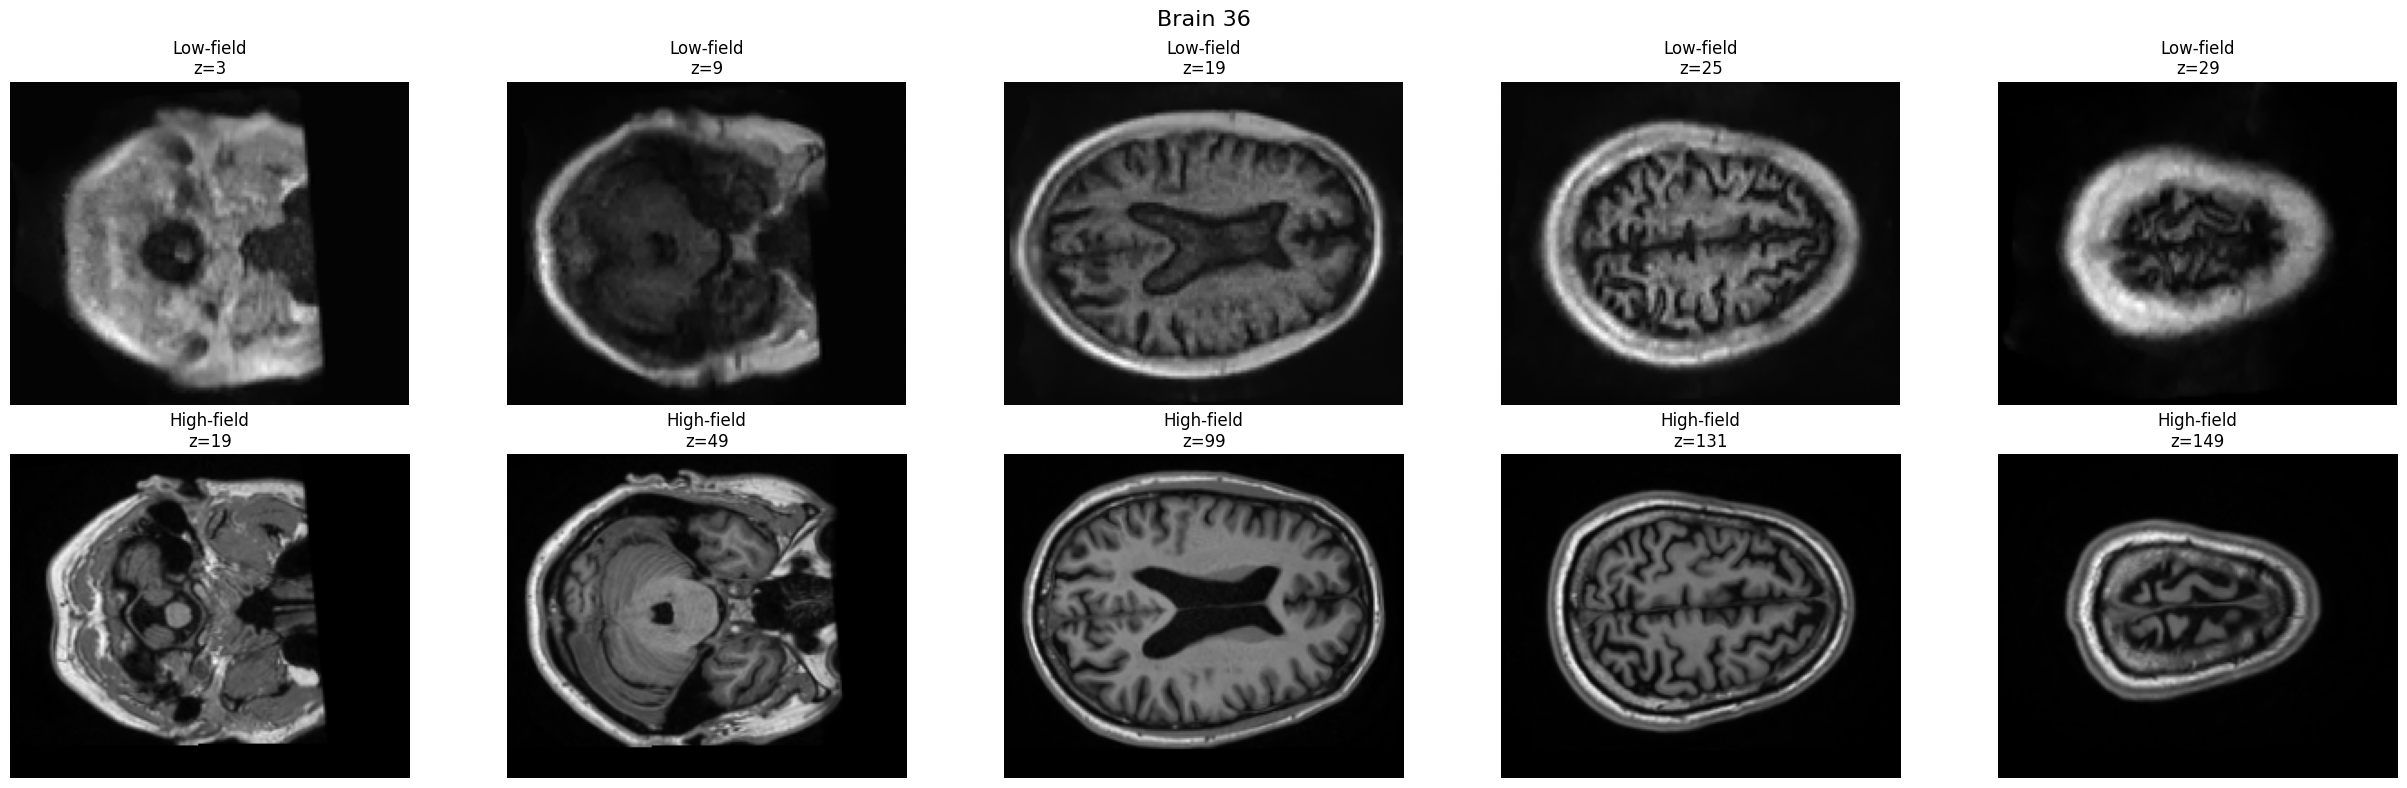

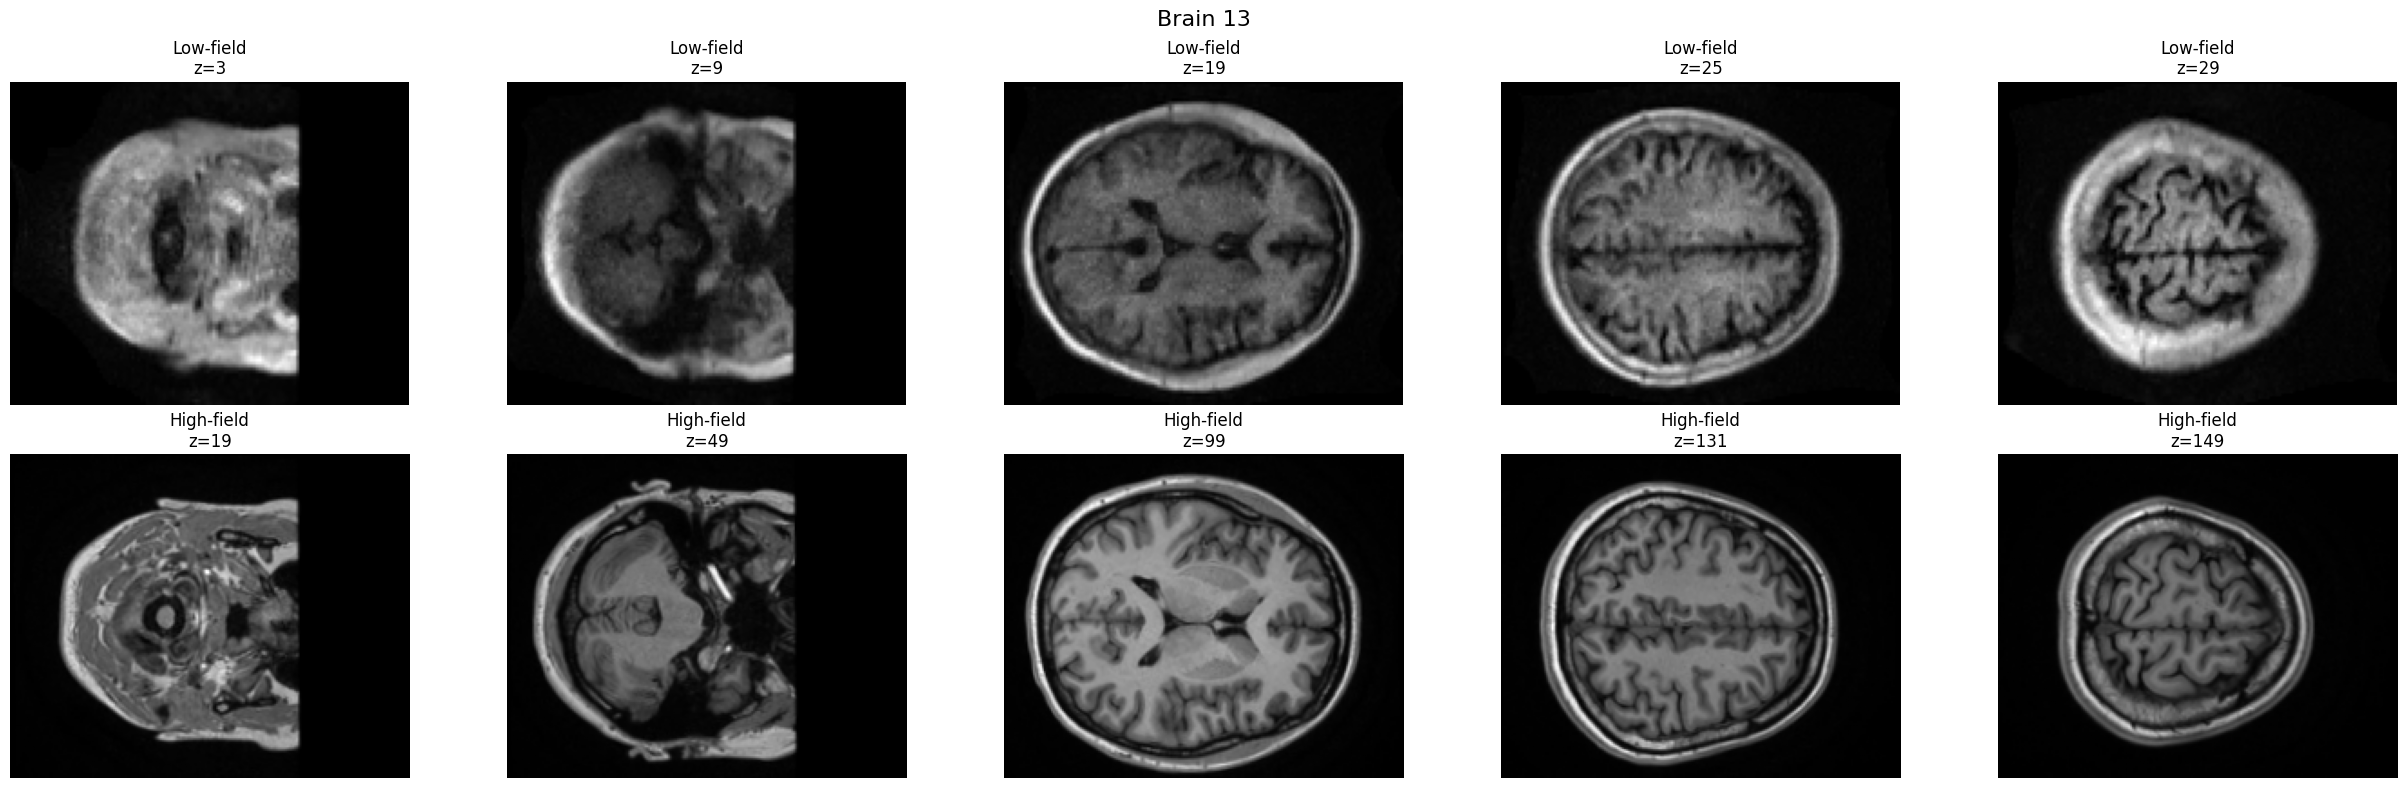

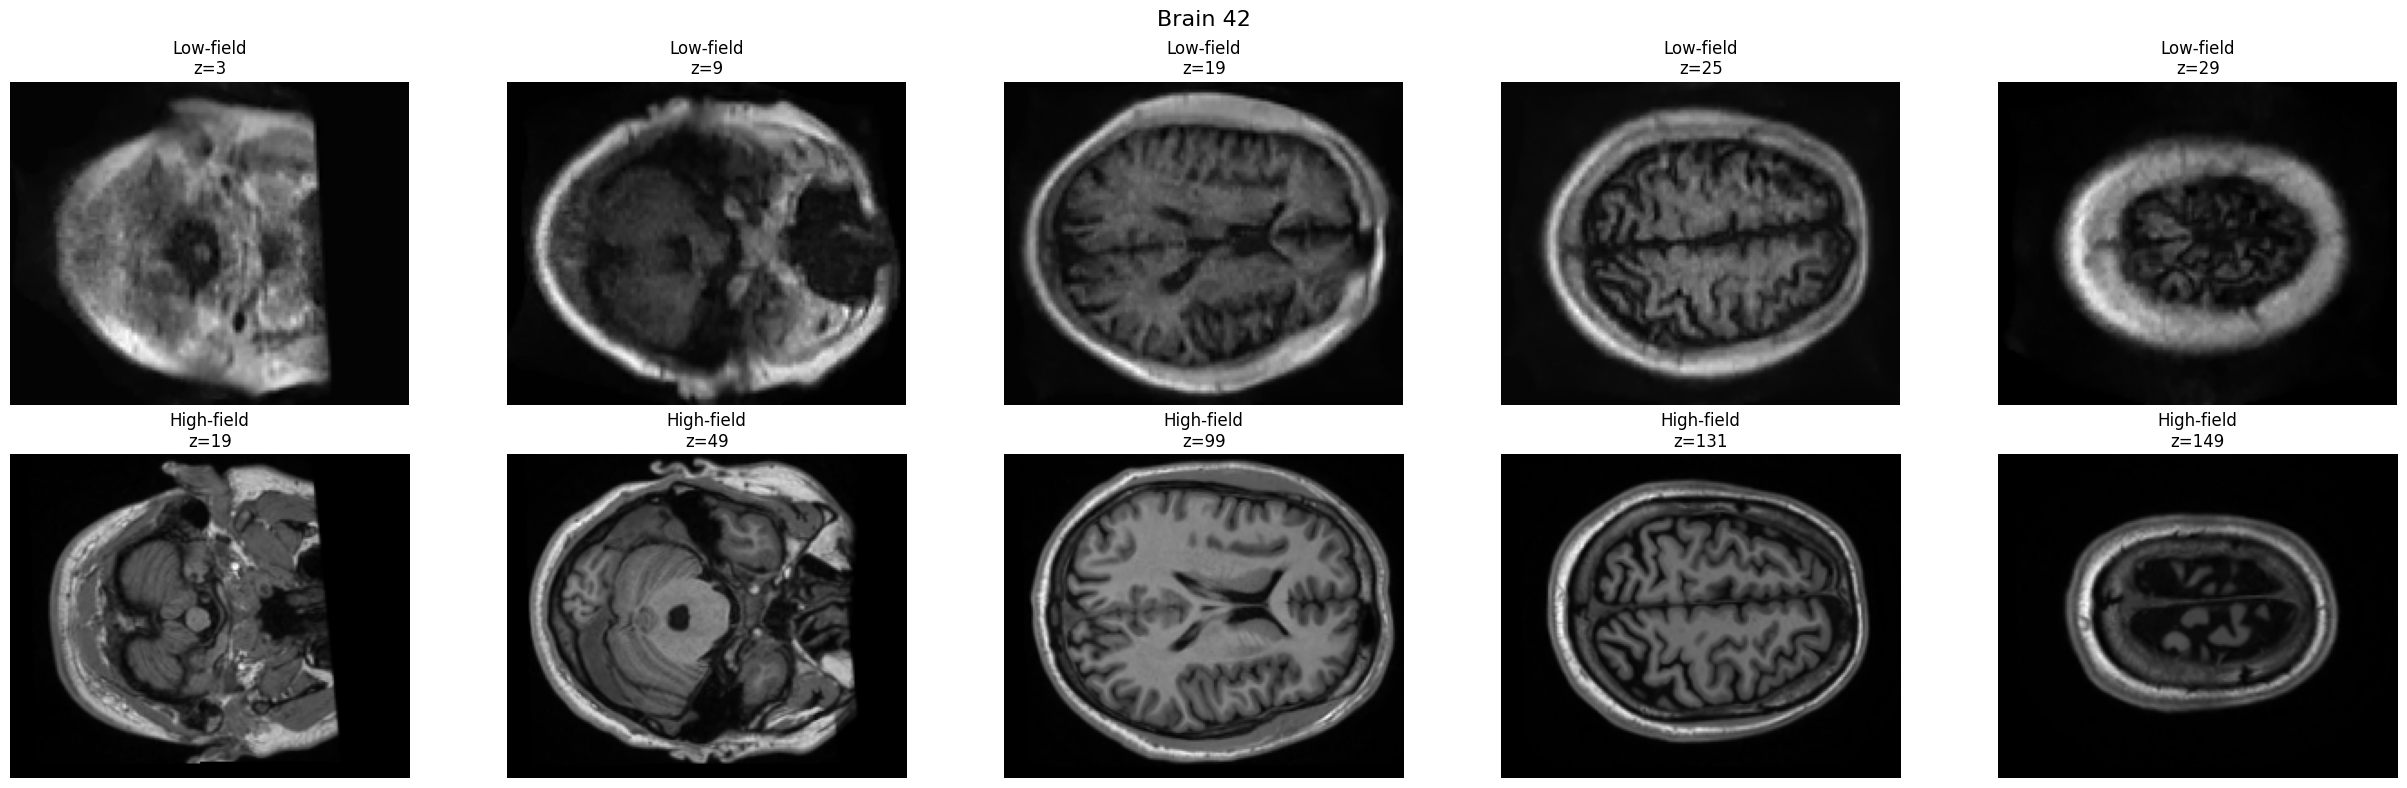

In [65]:
def plot_fractional_slices_pair(low, high, brain_id, fractions=(0.1, 0.25, 0.5, 0.66, 0.75)):
    low = ensure_3d(low)
    high = ensure_3d(high)

    zl = low.shape[2]
    zh = high.shape[2]

    low_idxs  = [int(f * (zl - 1)) for f in fractions]
    high_idxs = [int(f * (zh - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, (lz, hz) in enumerate(zip(low_idxs, high_idxs)):
        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(high[:, :, hz], cmap="gray")
        axes[1, j].set_title(f"High-field\nz={hz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id:02d}", fontsize=16)
    plt.tight_layout()
    plt.show()


selected_indices = random.sample(range(len(train_pairs)), 3)

print("Selected brains:", [i + 1 for i in selected_indices])

for i in selected_indices:
    low_path, high_path = train_pairs[i]

    img_low = nib.load(low_path)
    img_high = nib.load(high_path)

    plot_fractional_slices_pair(
        img_low.get_fdata(),
        img_high.get_fdata(),
        brain_id=i + 1
    )

In [66]:
def lowpass_mask(shape, cutoff):
    H, W = shape
    y = torch.linspace(-0.5, 0.5, H)
    x = torch.linspace(-0.5, 0.5, W)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= cutoff).float()

def add_rician_noise(x, sigma):
    noise_real = torch.randn_like(x) * sigma
    noise_imag = torch.randn_like(x) * sigma
    return torch.sqrt((x + noise_real)**2 + noise_imag**2)

def degrade(x_hr, scale=2, cutoff=0.25, noise_sigma=0.01):
    X = fft.fftshift(fft.fft2(x_hr))
    mask = lowpass_mask(X.shape[-2:], cutoff).to(X.device)
    X = X * mask
    x_lp = fft.ifft2(fft.ifftshift(X)).real
    x_lr = F.avg_pool2d(x_lp, kernel_size=scale)
    x_lr = add_rician_noise(x_lr, noise_sigma)
    return x_lr

def safe_residual(residual, cutoff):
    R = fft.fftshift(fft.fft2(residual))
    mask = lowpass_mask(R.shape[-2:], cutoff).to(R.device)
    R = R * mask
    return fft.ifft2(fft.ifftshift(R)).real

def reconstruct(model, y_lr, out_size=(179, 221), cutoff=0.35):
    y_up = F.interpolate(y_lr, size=out_size, mode="bilinear", align_corners=False)
    r = model(y_up)
    r_safe = safe_lowpass(r, cutoff)
    return y_up + r_safe

def tv_loss(x):
    dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
    dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
    return dx.mean() + dy.mean()

def physics_loss(x_hat, y_lr, lam=0.01):
    y_hat = degrade_xy(x_hat, y_lr)
    dc = F.mse_loss(y_hat, y_lr)
    return dc + lam * tv_loss(x_hat)

def load_nii(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data.astype(np.float32)

def normalize_mri(vol):
    p1, p99 = np.percentile(vol, (1, 99))
    vol = np.clip(vol, p1, p99)
    vol = (vol - p1) / (p99 - p1 + 1e-6)
    return vol.astype(np.float32)

def map_lr_to_hr_slice(k, lr_slices=40, hr_slices=200):
    return int((k / lr_slices) * hr_slices)

def safe_lowpass(x, cutoff):
    X = fft.fftshift(fft.fft2(x))
    mask = lowpass_mask(X.shape[-2:], cutoff).to(X.device)
    X = X * mask
    return fft.ifft2(fft.ifftshift(X)).real

def psnr(x, y):
    mse = F.mse_loss(x, y)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def ssim_metric(x, y):
    return ssim(x, y, data_range=1.0, size_average=True)

def normalize(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)

def get_slice(vol, idx):
    return vol[:, :, idx]

def center_crop(enc, dec):
    _, _, H, W = dec.shape
    enc_H, enc_W = enc.shape[2], enc.shape[3]

    start_y = (enc_H - H) // 2
    start_x = (enc_W - W) // 2

    return enc[:, :, start_y:start_y+H, start_x:start_x+W]

def degrade_xy(x_hat, y_lr, cutoff=0.35, noise_sigma=0.01):
    X = fft.fftshift(fft.fft2(x_hat))
    mask = lowpass_mask(X.shape[-2:], cutoff).to(X.device)
    X = X * mask
    x_lp = fft.ifft2(fft.ifftshift(X)).real
    x_lr = F.interpolate(
        x_lp,
        size=y_lr.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    n1 = torch.randn_like(x_lr) * noise_sigma
    n2 = torch.randn_like(x_lr) * noise_sigma
    return torch.sqrt((x_lr + n1) ** 2 + n2 ** 2)


In [67]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class LatentEncoder(nn.Module):
  def __init__(self, in_ch, latent_dim=8):
      super().__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_ch, 32, 3, padding=1),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d(1)
      )
      self.fc_mu = nn.Linear(32, latent_dim)
      self.fc_logvar = nn.Linear(32, latent_dim)

  def forward(self, x):
      h = self.conv(x).view(x.size(0), -1)
      mu = self.fc_mu(h)
      logvar = self.fc_logvar(h)
      return mu, logvar

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class PhysicsUNet(nn.Module):
    def __init__(self, base_ch=32, dropout=0.2):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(1, base_ch)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base_ch, base_ch * 2)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_ch * 2, base_ch * 4)

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec2 = DoubleConv(base_ch * 4, base_ch * 2)

        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec1 = DoubleConv(base_ch * 2, base_ch)

        # Output
        self.dropout = nn.Dropout2d(p=dropout)
        self.out = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Bottleneck
        b = self.bottleneck(self.pool2(e2))

        # Decoder
        d2 = self.up2(b)
        e2_crop = center_crop(e2, d2)
        d2 = torch.cat([d2, e2_crop], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1_crop = center_crop(e1, d1)
        d1 = torch.cat([d1, e1_crop], dim=1)
        d1 = self.dec1(d1)

        d1 = self.dropout(d1)
        out = self.out(d1)

        # Force same spatial size as input
        if out.shape[-2:] != x.shape[-2:]:
            out = F.interpolate(
                out,
                size=x.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

        return out


In [68]:
class MRINiftiSliceDataset(Dataset):
    def __init__(self, pair_paths):
        """
        pair_paths: list of [low_field_path, high_field_path]
        """
        self.samples = []

        for lf_path, hf_path in pair_paths:
            lr_vol = normalize_mri(load_nii(lf_path))
            hr_vol = normalize_mri(load_nii(hf_path))

            assert lr_vol.ndim == 3
            assert hr_vol.ndim == 3

            for k in range(lr_vol.shape[2]):
                z_hr = map_lr_to_hr_slice(k)
                self.samples.append((
                    lr_vol[:, :, k],
                    hr_vol[:, :, z_hr]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        y_lr, x_hr = self.samples[idx]
        return (
            torch.from_numpy(y_lr).unsqueeze(0),  # [1, H, W]
            torch.from_numpy(x_hr).unsqueeze(0)
        )


In [69]:
train_dataset = MRINiftiSliceDataset(train_pairs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

val_dataset = MRINiftiSliceDataset(val_pairs)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [70]:
def train(model, train_loader, val_loader, opt, ckpt_path="", type="physics_unet", epochs=100):
    best_val_loss = float("inf")

    # Load checkpoint if exists
    if ckpt_path and os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint from {ckpt_path}")
    else:
        print("No checkpoint found, training from scratch")

    for e in range(epochs):
        # Training
        model.train()
        train_loss_sum = 0.0

        for y_lr, _ in train_loader:
            y_lr = y_lr.to(device)

            x_hat = reconstruct(model, y_lr)
            loss = physics_loss(x_hat, y_lr)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss_sum += loss.item()

        train_loss = train_loss_sum / len(train_loader)

        # Validation
        model.eval()
        val_loss_sum = 0.0

        with torch.no_grad():
            for y_lr, _ in val_loader:
                y_lr = y_lr.to(device)

                x_hat = reconstruct(model, y_lr)
                loss = physics_loss(x_hat, y_lr)

                val_loss_sum += loss.item()

        val_loss = val_loss_sum / len(val_loader)

        print(
            f"Epoch {e+1}/{epochs} | "
            f"Train Loss: {train_loss:.6f} | "
            f"Val Loss: {val_loss:.6f}"
        )
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{type}_best.pth")
            print("Saved best model")

        # Periodic checkpoint
        if (e + 1) % 10 == 0:
            ckpt_name = f"{type}_{e+1}.pth"
            torch.save(model.state_dict(), ckpt_name)
            print(f"Saved checkpoint: {ckpt_name}")

    # Save final model
    torch.save(model.state_dict(), f"{type}_final.pth")
    print("Saved final model")

In [71]:
model = PhysicsUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
ckpt_path = "physics_unet_final.pth"

In [72]:
train(model, train_loader, val_loader, opt, ckpt_path, type="physics_unet", epochs=150)

Loaded checkpoint from physics_unet_final.pth
Epoch 1/150 | Train Loss: 0.000573 | Val Loss: 0.000542
Saved best model
Epoch 2/150 | Train Loss: 0.000573 | Val Loss: 0.000542
Saved best model
Epoch 3/150 | Train Loss: 0.000573 | Val Loss: 0.000541
Saved best model
Epoch 4/150 | Train Loss: 0.000573 | Val Loss: 0.000541
Saved best model
Epoch 5/150 | Train Loss: 0.000573 | Val Loss: 0.000540
Saved best model
Epoch 6/150 | Train Loss: 0.000573 | Val Loss: 0.000541
Epoch 7/150 | Train Loss: 0.000573 | Val Loss: 0.000541
Epoch 8/150 | Train Loss: 0.000573 | Val Loss: 0.000541


KeyboardInterrupt: 

In [ ]:
# !mkdir -p /content/drive/MyDrive/mri/models
!cp *.pth /content/drive/MyDrive/mri/models/
!cp *.pt /content/drive/MyDrive/mri/models/

Using device: cuda


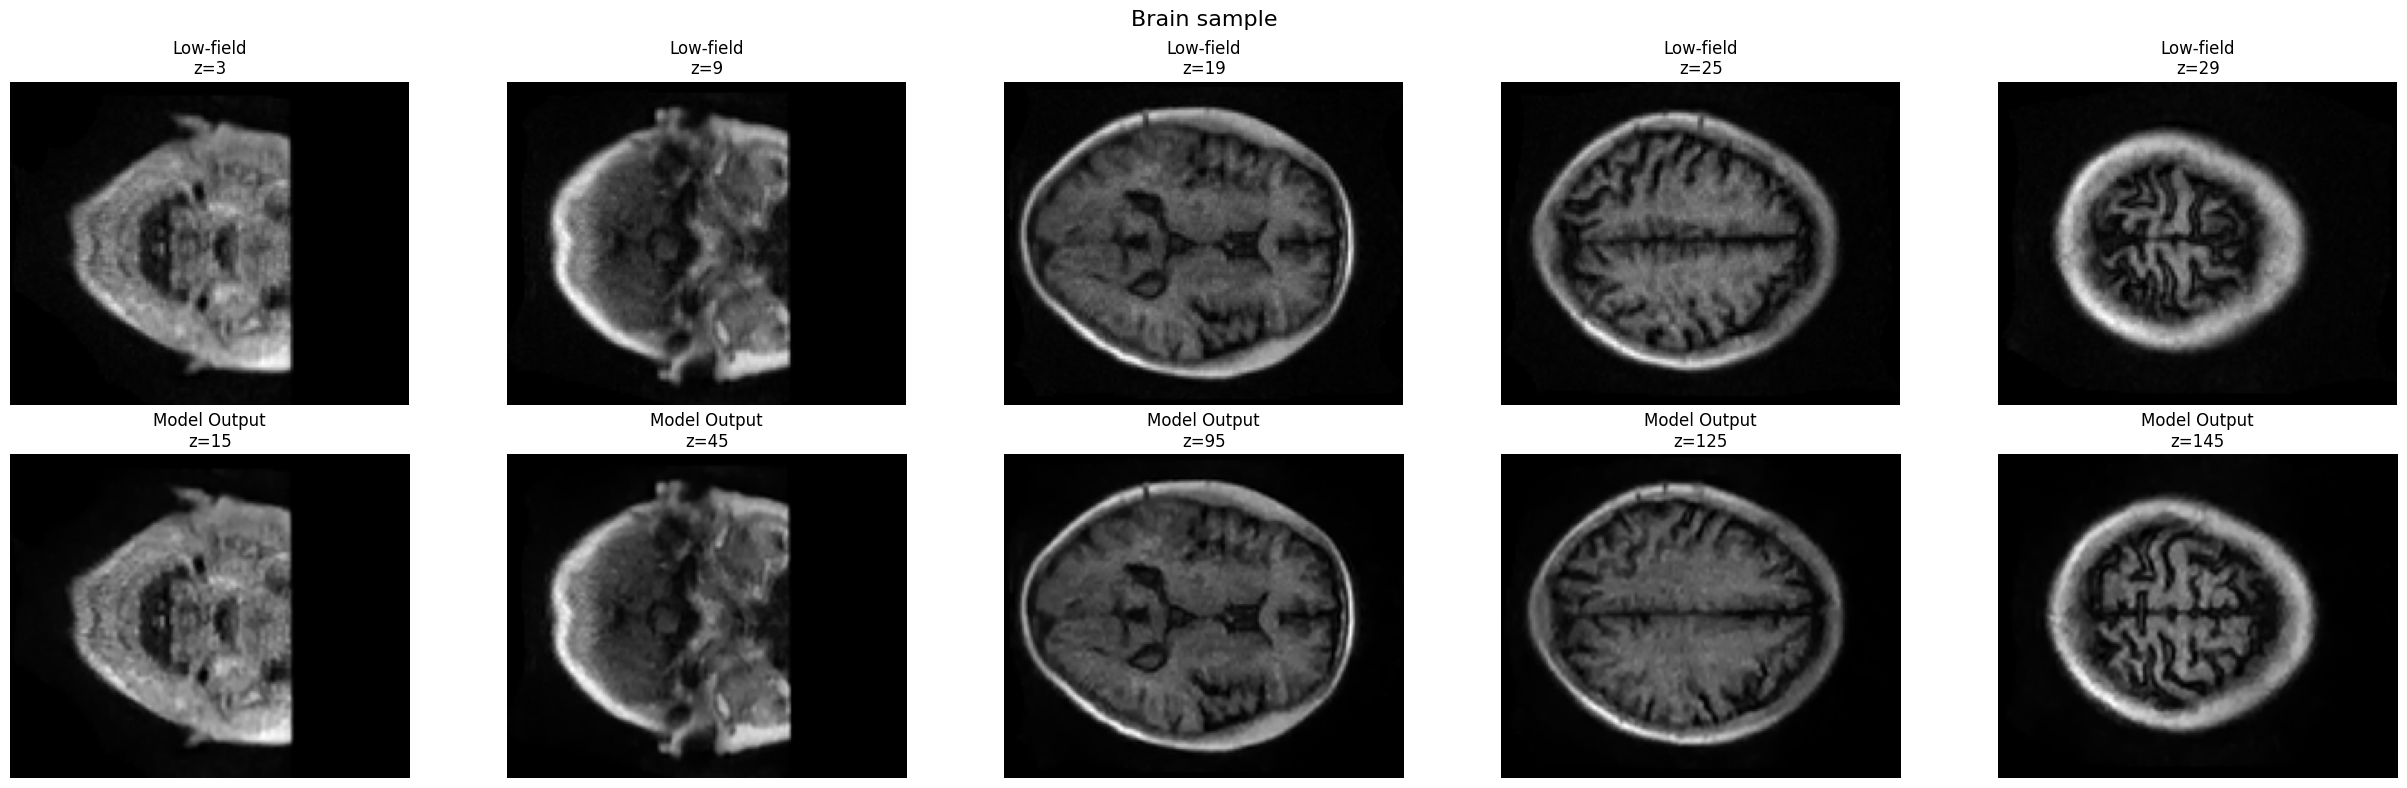

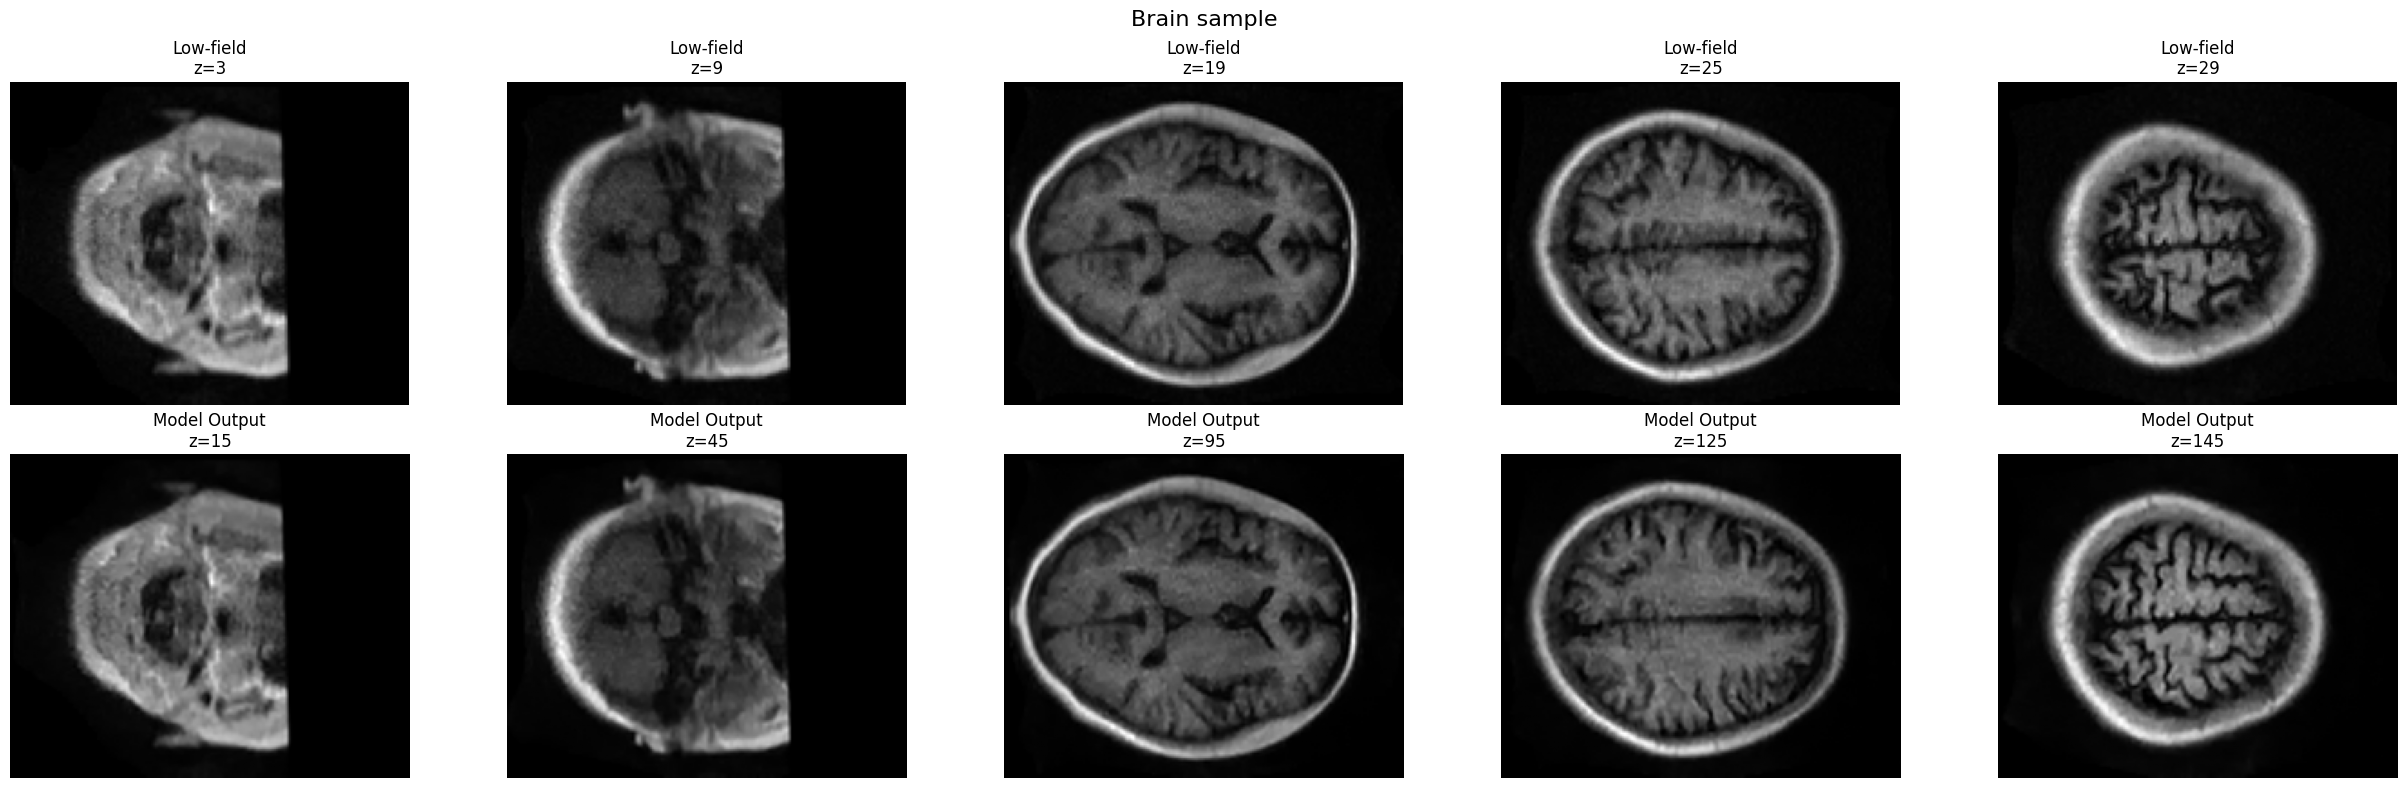

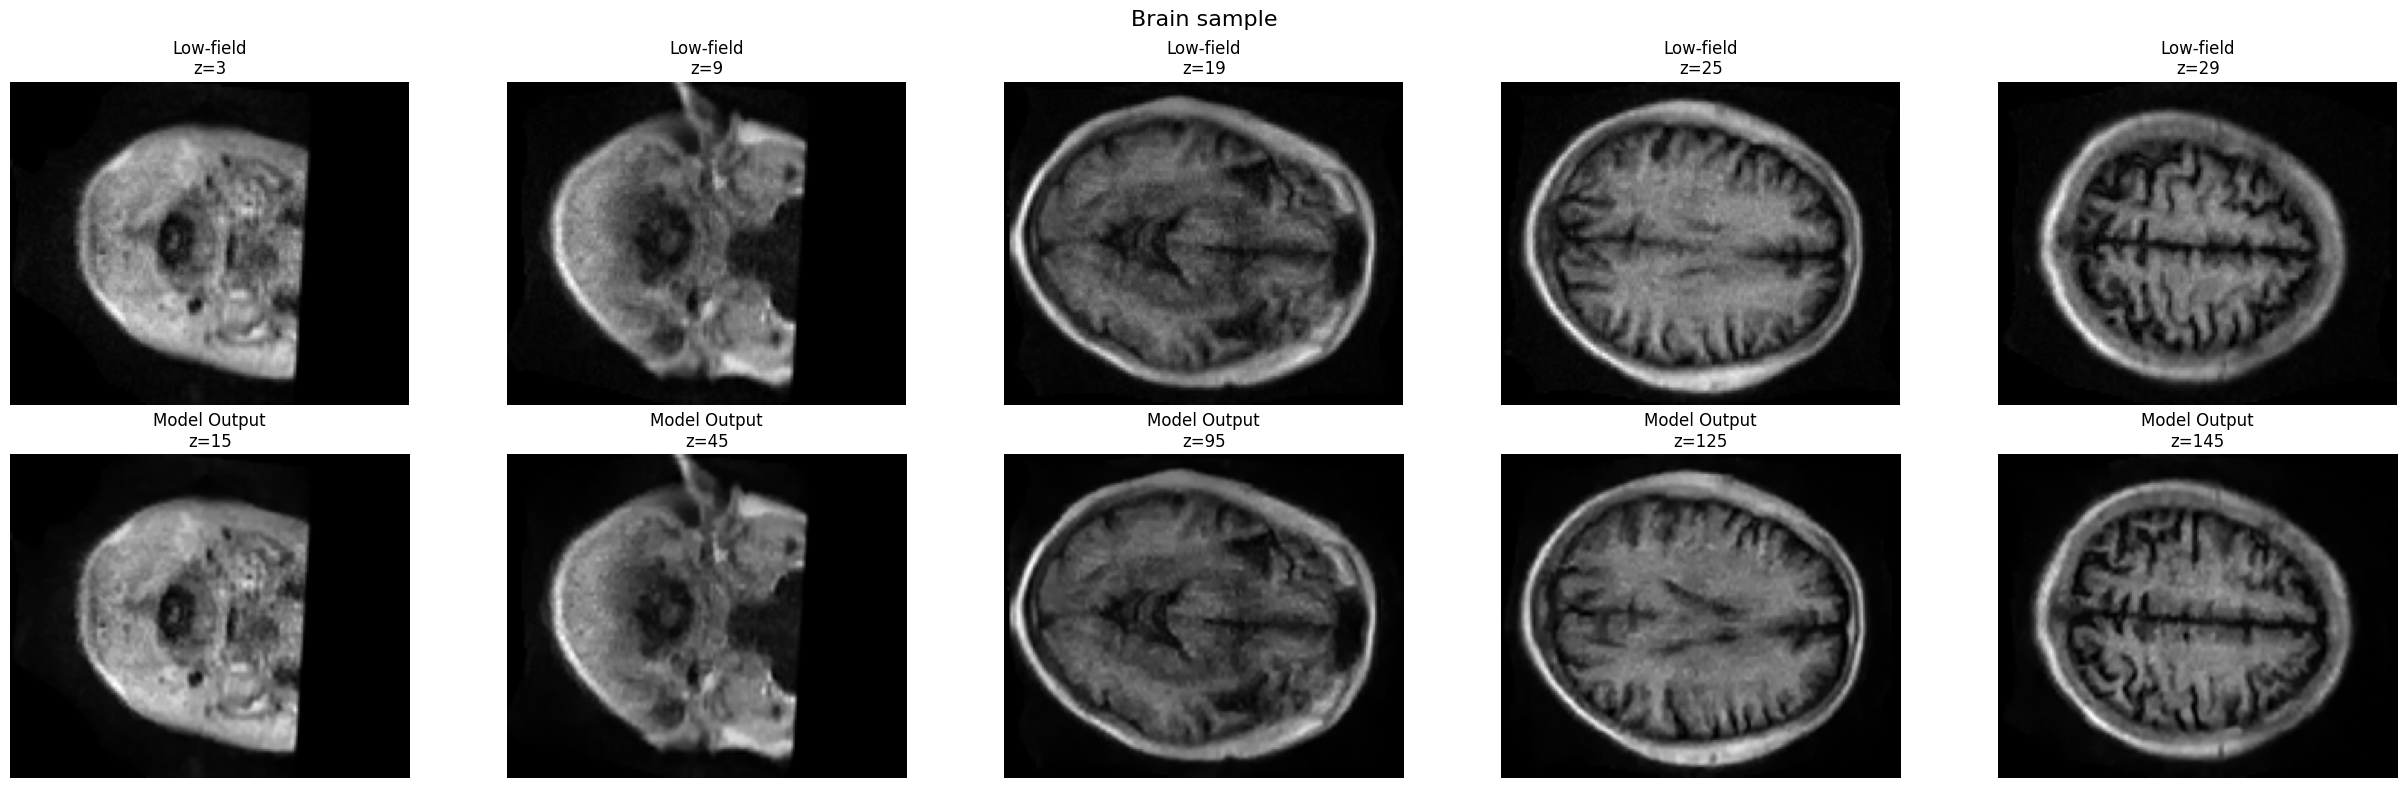

Processing sample_019...
Processing sample_020...
Processing sample_021...
Processing sample_022...
Processing sample_023...

 Submission saved as submission.csv
Total rows: 1000 (should be 1000)


In [73]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

print("Using device:", device)
LR_NIFTI_DIR = "/content/data/test/low_field"
MODEL_PATH   = "physics_unet_final.pth"
OUTPUT_CSV   = "submission.csv"
TARGET_SLICES = 200
model = PhysicsUNet().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
def ensure_3d(vol):
    if vol.ndim == 4:
        vol = vol[:, :, :, 0]
    return vol

def normalize_volume(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def upsample_z_deprecated(volume, target_slices=200):
    """
    volume: (H, W, Z)
    returns: (H, W, target_slices)
    """
    H, W, Z = volume.shape
    zoom_factor = target_slices / Z
    return np.zoom(volume, (1, 1, zoom_factor), order=1)

def upsample_z(volume, target_slices=200):
    H, W, Z = volume.shape
    idxs = np.round(
        np.linspace(0, Z - 1, target_slices)
    ).astype(int)
    return volume[:, :, idxs]

def mild_sharpen(x):
    blur = gaussian_filter(x, sigma=0.6)
    return np.clip(x + 0.15 * (x - blur), 0, 1)

# =========================
# MODEL RECONSTRUCTION
# =========================
def reconstruct_slice(model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].float().to(device)
    with torch.no_grad():
        x_hat = reconstruct(model, x)
    return x_hat.squeeze().cpu().numpy()

def reconstruct_volume(model, lr_vol):
    slices = []
    for z in range(lr_vol.shape[2]):
        slices.append(reconstruct_slice(model, lr_vol[:, :, z]))
    return np.stack(slices, axis=2)


# VISUALIZATION

def plot_fractional_slices_triplet(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(idxs), figsize=(5 * len(idxs), 8))

    for j, z in enumerate(idxs):
        axes[0, j].imshow(low[:, :, z], cmap="gray")
        axes[0, j].set_title(f"Low (z={z})")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, z], cmap="gray")
        axes[1, j].set_title("Model Output")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================
# BASE64 ENCODING
# =========================
def slice_to_base64(slice_2d):
    smin, smax = float(slice_2d.min()), float(slice_2d.max())
    if smax > smin:
        norm = ((slice_2d - smin) / (smax - smin) * 255).astype(np.uint8)
    else:
        norm = np.zeros_like(slice_2d, dtype=np.uint8)

    buf = io.BytesIO()
    np.savez_compressed(buf,
                        slice=norm,
                        shape=slice_2d.shape,
                        min_val=smin,
                        max_val=smax)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

def volume_to_rows(volume, sample_id):
    rows = []
    for z in range(volume.shape[2]):  # now guaranteed 200
        rows.append({
            "row_id": f"{sample_id}_slice_{z:03d}",
            "prediction": slice_to_base64(volume[:, :, z])
        })
    return rows

all_rows = []

nii_files = sorted([
    f for f in os.listdir(LR_NIFTI_DIR)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])

# ---- VISUALIZE SOME SAMPLES ----
def plot_fractional_slices_low_vs_model(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    zp = pred.shape[2]

    low_idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, lz in enumerate(low_idxs):
        pz = int(lz * zp / zl)

        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, pz], cmap="gray")
        axes[1, j].set_title(f"Model Output\nz={pz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

viz_samples = random.sample(nii_files, min(3, len(nii_files)))

for fname in viz_samples:
    sample_id = fname.split("_")[0]
    path = os.path.join(LR_NIFTI_DIR, fname)

    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(model, lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    plot_fractional_slices_low_vs_model(
        low=lr_vol,
        pred=pred_vol,
        brain_id=sample_id,
    )

# ---- CREATE SUBMISSION ----
for fname in nii_files:
    parts = fname.split("_")
    sample_id = f"{parts[0]}_{parts[1]}"
    path = os.path.join(LR_NIFTI_DIR, fname)

    print(f"Processing {sample_id}...")
    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(model, lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    assert pred_vol.shape[2] == TARGET_SLICES

    all_rows.extend(volume_to_rows(pred_vol, sample_id))

df = pd.DataFrame(all_rows)
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n Submission saved as {OUTPUT_CSV}")
print(f"Total rows: {len(df)} (should be {len(nii_files) * TARGET_SLICES})")

In [74]:
physics_model = PhysicsUNet().to(device)
physics_model.load_state_dict(torch.load("physics_unet_final.pth"))
physics_model.eval()

for p in physics_model.parameters():
    p.requires_grad = False

In [75]:
residual_model = PhysicsUNet().to(device)

In [80]:
def train_residual():
    # Load frozen physics model
    physics_model = PhysicsUNet().to(device)
    physics_model.load_state_dict(torch.load("physics_unet_final.pth", map_location=device))
    physics_model.eval()
    for p in physics_model.parameters():
        p.requires_grad = False

    # Residual model
    residual_model = PhysicsUNet().to(device)
    opt = torch.optim.Adam(residual_model.parameters(), lr=1e-4)

    epochs = 150
    for e in range(epochs):
        residual_model.train()
        loss_sum = 0.0

        for y_lr, x_hr in train_loader:
            y_lr = y_lr.to(device)
            x_hr = x_hr.to(device)

            # Step 1: physics reconstruction
            with torch.no_grad():
                x_phys = reconstruct(
                    physics_model,
                    y_lr,
                    out_size=x_hr.shape[-2:]
                )

            # Step 2: residual target
            residual_gt = x_hr - x_phys

            # Step 3: residual prediction
            r_pred = residual_model(x_phys)

            # Step 4: supervised residual loss
            x_final = x_phys + 0.6 * r_pred

            # residual supervision
            l_res = F.l1_loss(r_pred, residual_gt)

            # weak physics consistency
            l_phys = physics_loss(x_final, y_lr)

            loss = l_res + 0.05 * l_phys

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        print(f"Epoch {e+1}/{epochs} | Residual Loss {loss_sum / len(train_loader):.6f}")

        # Save checkpoint every 10 epochs
        if (e + 1) % 10 == 0:
            current_ckpt = f"residual_unet_{e+1}.pth"
            prev_ckpt = f"residual_unet_{e-9}.pth"

            if os.path.exists(prev_ckpt):
                os.remove(prev_ckpt)
                print(f"Deleted old checkpoint: {prev_ckpt}")

            torch.save(residual_model.state_dict(), current_ckpt)
            print(f"Saved checkpoint: {current_ckpt}")

    # Final save
    rand = random.randint(1000, 9999)
    prev_ckpt = f"residual_unet_{(epochs // 10) * 10}.pth"

    if os.path.exists(prev_ckpt):
        os.remove(prev_ckpt)
        print(f"Deleted old checkpoint: {prev_ckpt}")

    final_path = f"residual_unet_final.pth"
    torch.save(residual_model.state_dict(), final_path)
    print(f"Saved final residual model: {final_path}")

In [82]:
train_residual()

Epoch 1/150 | Residual Loss 0.096422
Epoch 2/150 | Residual Loss 0.087789
Epoch 3/150 | Residual Loss 0.082723
Epoch 4/150 | Residual Loss 0.079736
Epoch 5/150 | Residual Loss 0.077256
Epoch 6/150 | Residual Loss 0.075430
Epoch 7/150 | Residual Loss 0.073967
Epoch 8/150 | Residual Loss 0.072436
Epoch 9/150 | Residual Loss 0.071519
Epoch 10/150 | Residual Loss 0.070383
Saved checkpoint: residual_unet_10.pth
Epoch 11/150 | Residual Loss 0.069541
Epoch 12/150 | Residual Loss 0.068794
Epoch 13/150 | Residual Loss 0.068138
Epoch 14/150 | Residual Loss 0.067184
Epoch 15/150 | Residual Loss 0.066591
Epoch 16/150 | Residual Loss 0.066239
Epoch 17/150 | Residual Loss 0.065738
Epoch 18/150 | Residual Loss 0.065124
Epoch 19/150 | Residual Loss 0.064591
Epoch 20/150 | Residual Loss 0.064112
Deleted old checkpoint: residual_unet_10.pth
Saved checkpoint: residual_unet_20.pth
Epoch 21/150 | Residual Loss 0.063745
Epoch 22/150 | Residual Loss 0.063352
Epoch 23/150 | Residual Loss 0.062868
Epoch 24/150

In [83]:
!cp *.pth /content/drive/MyDrive/mri/models/
!cp *.pt /content/drive/MyDrive/mri/models/

cp: cannot stat '*.pt': No such file or directory


In [84]:
PHYSICS_MODEL_PATH  = "physics_unet_final.pth"
RESIDUAL_MODEL_PATH = "residual_unet_final.pth"

physics_model = PhysicsUNet().to(device)
physics_model.load_state_dict(torch.load(PHYSICS_MODEL_PATH, map_location=device))
physics_model.eval()

residual_model = PhysicsUNet().to(device)
residual_model.load_state_dict(torch.load(RESIDUAL_MODEL_PATH, map_location=device))
residual_model.eval()

PhysicsUNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )


In [85]:
def ensure_3d(vol):
    if vol.ndim == 4:
        vol = vol[:, :, :, 0]
    return vol

def normalize_volume(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def upsample_z_deprecated(volume, target_slices=200):
    """
    volume: (H, W, Z)
    returns: (H, W, target_slices)
    """
    H, W, Z = volume.shape
    zoom_factor = target_slices / Z
    return np.zoom(volume, (1, 1, zoom_factor), order=1)

def upsample_z(volume, target_slices=200):
    H, W, Z = volume.shape
    idxs = np.round(
        np.linspace(0, Z - 1, target_slices)
    ).astype(int)
    return volume[:, :, idxs]

def mild_sharpen(x):
    blur = gaussian_filter(x, sigma=0.6)
    return np.clip(x + 0.15 * (x - blur), 0, 1)

# =========================
# MODEL RECONSTRUCTION
# =========================
TARGET_SIZE = (179, 221)

def reconstruct_slice(physics_model, residual_model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].float().to(device)

    with torch.no_grad():
        # Stage 1: physics reconstruction to HR size
        x_phys = reconstruct(
            physics_model,
            x,
            out_size=TARGET_SIZE
        )

        # Stage 2: residual refinement
        r_pred = residual_model(x_phys)

        # Final output (with scaling if you use it)
        x_final = x_phys + 0.3805 * r_pred

    return x_final.squeeze().cpu().numpy()

def reconstruct_volume(physics_model, residual_model, lr_vol):
    slices = []
    for z in range(lr_vol.shape[2]):
        slices.append(
            reconstruct_slice(
                physics_model,
                residual_model,
                lr_vol[:, :, z]
            )
        )
    return np.stack(slices, axis=2)

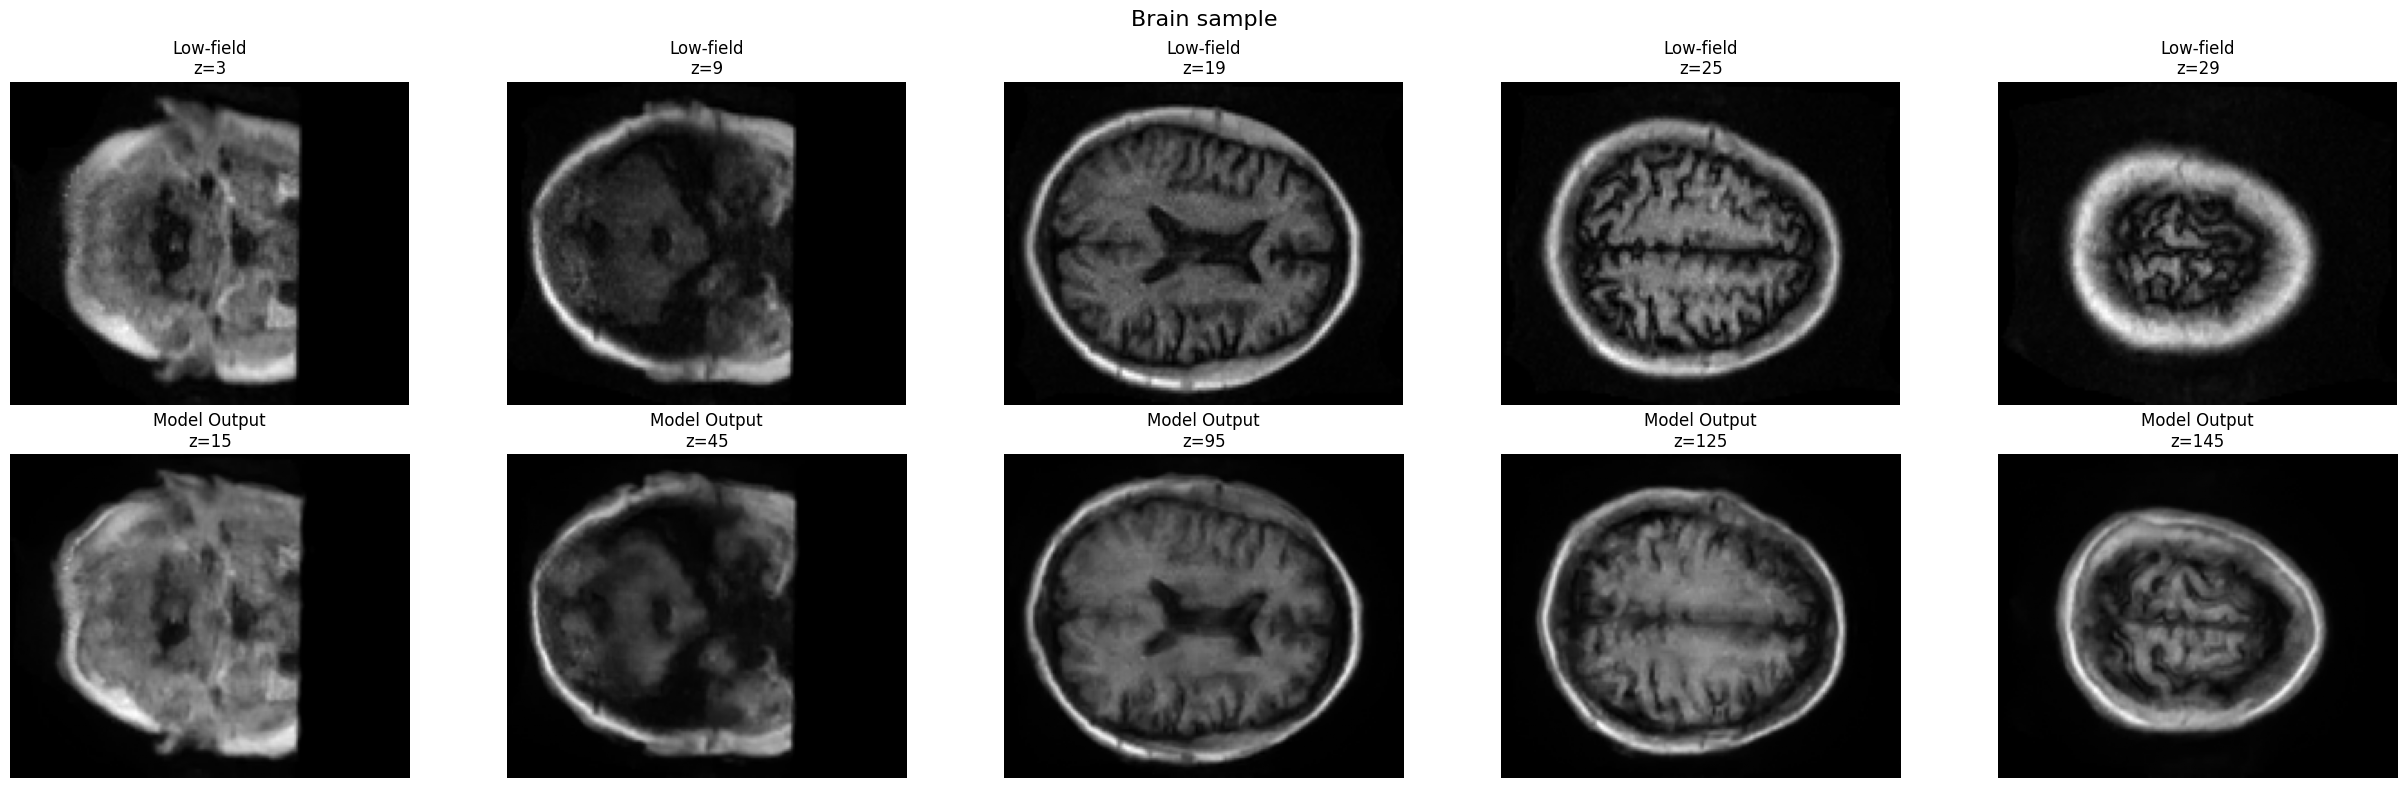

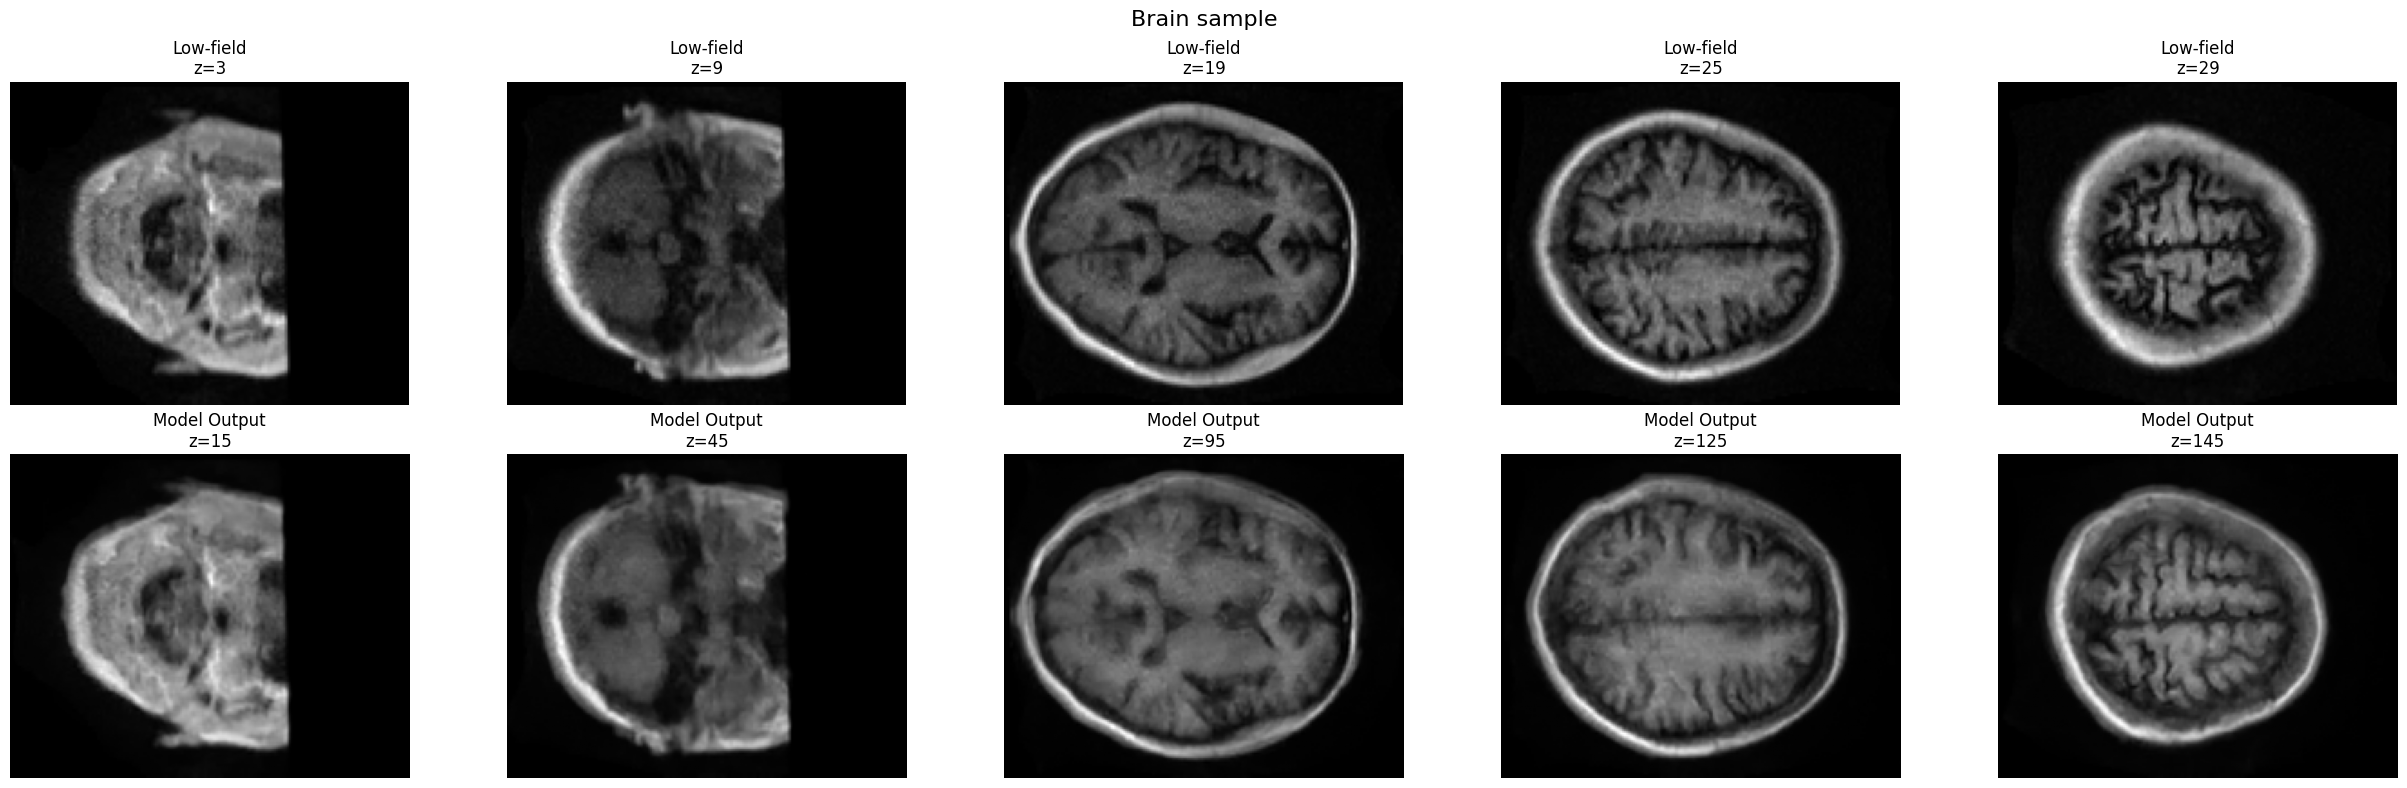

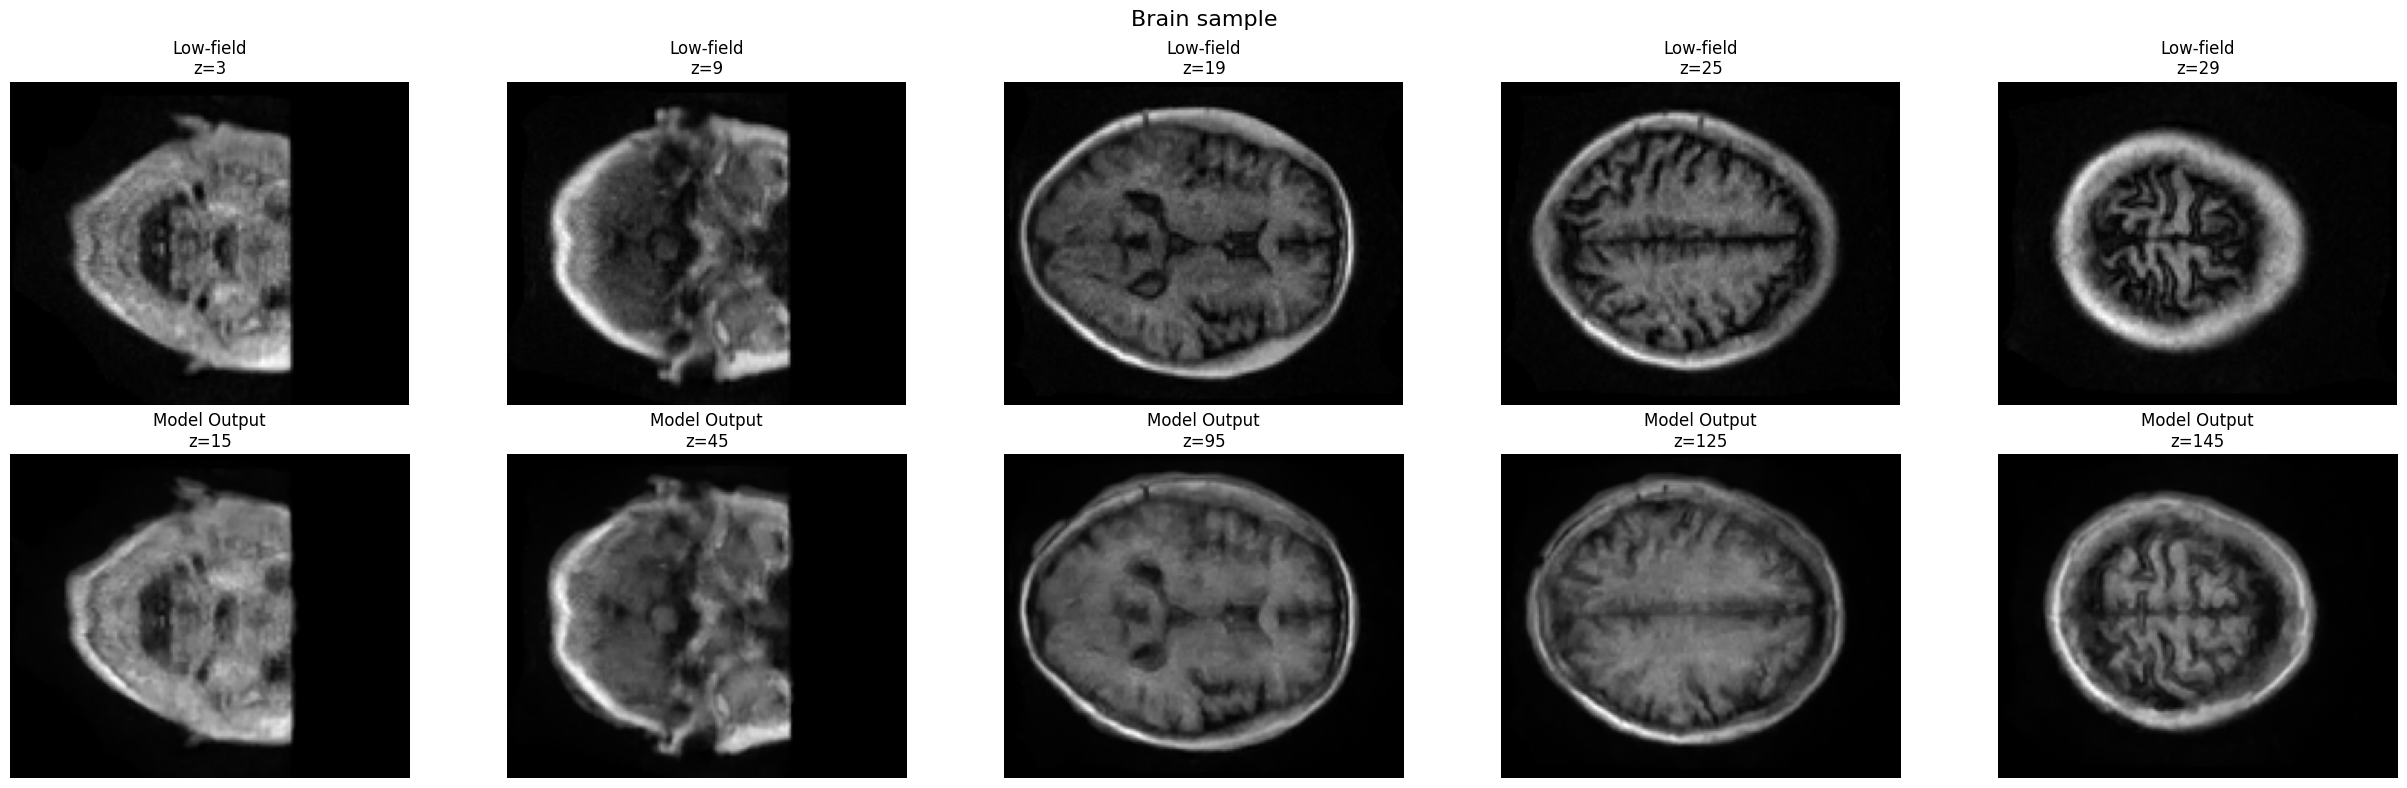

Processing sample_019...
(179, 221, 200)
Processing sample_020...
(179, 221, 200)
Processing sample_021...
(179, 221, 200)
Processing sample_022...
(179, 221, 200)
Processing sample_023...
(179, 221, 200)

 Submission saved as submission.csv
Total rows: 1000 (should be 1000)


In [87]:

# VISUALIZATION

def plot_fractional_slices_triplet(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(idxs), figsize=(5 * len(idxs), 8))

    for j, z in enumerate(idxs):
        axes[0, j].imshow(low[:, :, z], cmap="gray")
        axes[0, j].set_title(f"Low (z={z})")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, z], cmap="gray")
        axes[1, j].set_title("Model Output")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================
# BASE64 ENCODING
# =========================
def slice_to_base64(slice_2d):
    smin, smax = float(slice_2d.min()), float(slice_2d.max())
    if smax > smin:
        norm = ((slice_2d - smin) / (smax - smin) * 255).astype(np.uint8)
    else:
        norm = np.zeros_like(slice_2d, dtype=np.uint8)

    buf = io.BytesIO()
    np.savez_compressed(buf,
                        slice=norm,
                        shape=slice_2d.shape,
                        min_val=smin,
                        max_val=smax)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

def volume_to_rows(volume, sample_id):
    rows = []
    for z in range(volume.shape[2]):  # now guaranteed 200
        rows.append({
            "row_id": f"{sample_id}_slice_{z:03d}",
            "prediction": slice_to_base64(volume[:, :, z])
        })
    return rows

all_rows = []

nii_files = sorted([
    f for f in os.listdir(LR_NIFTI_DIR)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])

# ---- VISUALIZE SOME SAMPLES ----
def plot_fractional_slices_low_vs_model(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    zp = pred.shape[2]

    low_idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, lz in enumerate(low_idxs):
        pz = int(lz * zp / zl)

        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, pz], cmap="gray")
        axes[1, j].set_title(f"Model Output\nz={pz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

viz_samples = random.sample(nii_files, min(3, len(nii_files)))

for fname in viz_samples:
    sample_id = fname.split("_")[0]
    path = os.path.join(LR_NIFTI_DIR, fname)

    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(
        physics_model,
        residual_model,
        lr_vol
    )

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    plot_fractional_slices_low_vs_model(
        low=lr_vol,
        pred=pred_vol,
        brain_id=sample_id,
    )

# ---- CREATE SUBMISSION ----
for fname in nii_files:
    parts = fname.split("_")
    sample_id = f"{parts[0]}_{parts[1]}"
    path = os.path.join(LR_NIFTI_DIR, fname)

    print(f"Processing {sample_id}...")
    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(physics_model,
        residual_model,
        lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    assert pred_vol.shape[2] == TARGET_SLICES
    print(pred_vol.shape)

    all_rows.extend(volume_to_rows(pred_vol, sample_id))

df = pd.DataFrame(all_rows)
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n Submission saved as {OUTPUT_CSV}")
print(f"Total rows: {len(df)} (should be {len(nii_files) * TARGET_SLICES})")

In [88]:
x = 5
x

5